# Study case: Cu FCC lectures

In [1]:
# some constants
Ry_to_eV = 13.6057039763
Bohr_to_A = 0.529177
eV_to_J = 1.60218e-19

## Task 1: test the convergence properties

Choose appropriate alat,ecutwfc, ecutrho, ksampling values

1. For latParam we could follow the approach explain in the course [CompMatPhys](https://www.compmatphys.org/), but it is a bit cumbersome (do a full relax calculation for different pressures)... and not needed for FCC system (only a lattice param varies). In this way, we will only change alat in a certain range and compute the SCF energy
2. For ecutwfc, we simply change its value from 20 to 40 Ry and asses the difference in terms of LatParam, plus fit accuracy wrt EoS.
   

Points 1 and 2 were done together using three tools: ASE (https://wiki.fysik.dtu.dk/ase/tutorials/eos/eos.html), ev.x tool from quantum espresso and one script provided during the lectures (`murn_FHI.x`).

For the provided script, we need to create an `input.in` file with several characteristics:
```bash
1 # conversion A-Bohr
0.25 # Bulk modulus (volume) correction
5.9 7.4 500 # alat start, end, # points
10 # n points
6.1000 -122.67091882
6.3000 -122.70817076
6.4000 -122.72079456
6.5000 -122.73015291
6.6000 -122.73668686
6.7000 -122.74079958
6.8000 -122.74286627
6.9000 -122.74322940
7.0000 -122.74218711
7.1000 -122.73998748
```
the last lines are composed by the LatParam (Bohr) vs Energy (Ry). Note that in this script we must provide the volume unit cell reduction (for FCC lattice = 0.25; can be relatively straightforward proved by considering the unit cell vectors and volume as $v = \vec{a}_1 \times | \vec{a}_2 * \vec{a}_3 |$), **this is automatically considered in ev.x**.

For ASE, we simply can divide the data using the numpy arrays, check the `ase_plots.ipynb` file.

For `ev.x`, we should create a dat file with the left column as the alat parameter (bohr or angstrom) -also volume is viable, but normally it's better alat values- and the energy on the other column.

3. Compare and assess results searching for experimental ones, see e.g. https://mateck.com/en/content/26-copper-single-crystal-29cu63-54 for some of them. a=361.47 pm; B0 = 137.8 GPa. See also https://www.copper.org/resources/properties/atomic_properties.html

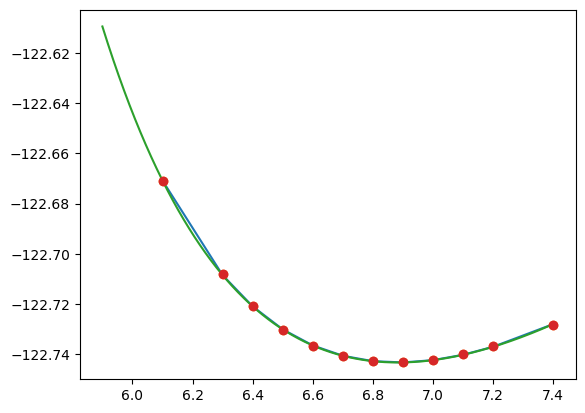

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.eos import EquationOfState
from ase import Atoms
from ase.units import kJ

# let's plot 40 Ry values using the three different methods

# 1) ASE
data_ecut40 = np.loadtxt('FCC_Cu/ecut40/energyvol.dat')
energy_40 = data_ecut40[:,1]
volume_40 = data_ecut40[:,0]
eos_40 = EquationOfState(volume_40, energy_40, eos='murnaghan')
v0, e0, B = eos_40.fit()
#eos_40.plot()

# 2) ev.x -- a0 = 6.8830 Bohr (3.64233 A), B0 = 137.5 GPa, V_0 = 81.52 Bohr**3 (12.08 A**3), Emin = -122.74326
data_evx = np.loadtxt('FCC_Cu/ecut40/murn_evx.out',skiprows=8)
energy_evx = data_evx[:,1]
efit_evx = data_evx[:,2]
alat_evx = data_evx[:,0]
# plt.plot(alat_evx,efit_evx)
# plt.plot(alat_evx,energy_evx,'o')

# 3) murn_FHI.x -- alat = 6.8830 Bohr (3.6423 A), B0 = 137.5 GPa
data_fhi = np.loadtxt('FCC_Cu/ecut40/murn.out',skiprows=62)

plt.plot(alat_evx,efit_evx)
plt.plot(alat_evx,energy_evx,'o')
plt.plot(data_fhi[:,2],data_fhi[:,1])
plt.plot(alat_evx,energy_evx,'o');

# so each one of them is consistent, ASE gives a problem for B0, but has to be with the units, I am not able to solve it.

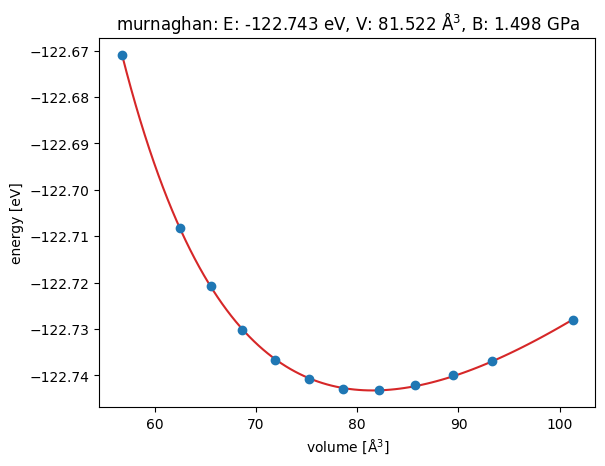

In [3]:
eos_40.plot();

**Note:** for the next plots, it is safer to prevent changes in volume larger than 10% when doing such analyses (see the considerations of the EoS validities), furthermore, greater volume changes can give convergence problems. In this example is fine as long as the volume does not change much more than $80\pm8 A^3$

comparing to ecutwfc, it is practically indistinguishable, so we can choose either 35 or 40 Ry, I will choose the second. Now, for our selected alat, I am running `vc-relax` to change how it further changes.

```bash
End of BFGS Geometry Optimization

     Final enthalpy           =    -122.7433110128 Ry

     File ./pwscf.bfgs deleted, as requested
Begin final coordinates
     new unit-cell volume =     80.68051 a.u.^3 (    11.95562 Ang^3 )
     density =      8.82603 g/cm^3

CELL_PARAMETERS (alat=  6.88300000)
  -0.498274255   0.000000000   0.498274255
  -0.000000000   0.498274255   0.498274255
  -0.498274255   0.498274255  -0.000000000

ATOMIC_POSITIONS (angstrom)
Cu           -0.0000000000        0.0000000000        0.0000000000
End final coordinates
```
which gives an alat of 3.6298 A (6.8592 Bohr). Experimental value gives 3.6147 A. Note the clear improvement when compared to the non-relaxed structure, which gives an a = 3.6423 A. Running an SCF using the newly optimised parameters with ibrav = 2, gives us:
```bash
  the Fermi energy is    12.4804 ev

!    total energy              =    -122.74326766 Ry
     estimated scf accuracy    <          5.7E-09 Ry
     smearing contrib. (-TS)   =      -0.00079015 Ry
     internal energy E=F+TS    =    -122.74247751 Ry

     The total energy is F=E-TS. E is the sum of the following terms:
     one-electron contribution =     -28.05400005 Ry
     hartree contribution      =      30.81729859 Ry
     xc contribution           =     -44.62632786 Ry
     ewald contribution        =     -80.87944818 Ry

     convergence has been achieved in   6 iterations

(...)
     Computing stress (Cartesian axis) and pressure

          total   stress  (Ry/bohr**3)                   (kbar)     P=       -0.87
  -0.00000594   0.00000000   0.00000000           -0.87        0.00        0.00
   0.00000000  -0.00000594   0.00000000            0.00       -0.87        0.00
   0.00000000   0.00000000  -0.00000594            0.00        0.00       -0.87

```
P lower than 1 kbar, which is optimal. We would thus use that lattice parameter value together with ecutwfc of 40 Ry and ecutrho=8*ecutwfc. Getting a more accurate B0 is a more cumbersome task, we would need to converge each of the previous calculations at vc-relax level for each target pressure. Nonetheless, the obtained value is already OK.

For selecting the proper ksampling, I will use the stress tensor formalism: the hydrostatic pressure is known to be a sensible parameter towards numerical precission. Values lower than 1-1.5 kbar would hence be safe to use as k-mesh.

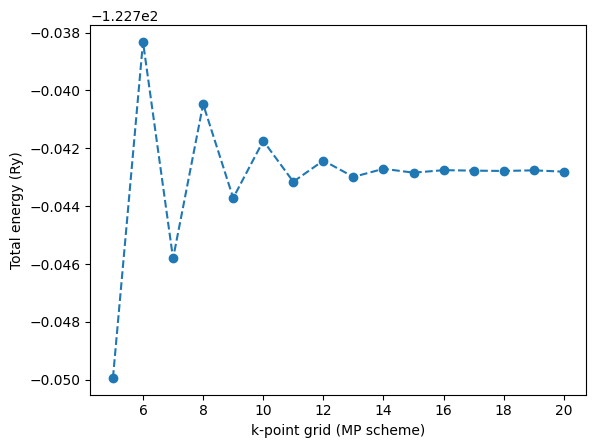

In [4]:
data_y = np.loadtxt('FCC_Cu/ksampling/violet/energies.dat')
data_x = np.arange(5,21,1)
plt.ylabel("Total energy (Ry)")
plt.xlabel("k-point grid (MP scheme)")
plt.plot(data_x,data_y,linestyle='--',marker='o');

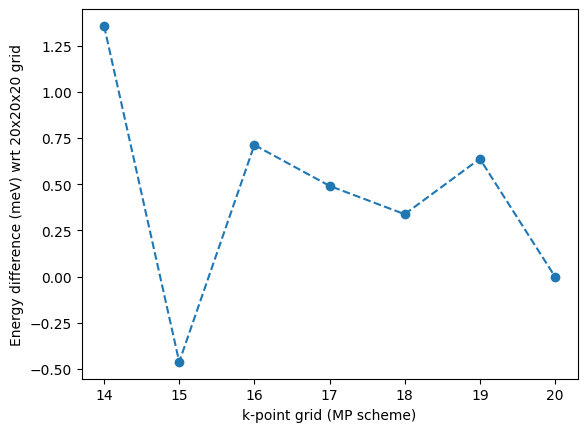

In [5]:
diff = np.array([value - data_y[-1] for index, value in enumerate(data_y)])*Ry_to_eV*1000
plt.ylabel("Energy difference (meV) wrt 20x20x20 grid")
plt.xlabel("k-point grid (MP scheme)")
plt.plot(data_x[9:],diff[9:],linestyle='--',marker='o');

See that the energy converges, so 15x15x15 seems like a reasonable grid (error in the range of 0.3 meV). I computed the pressures but it is somewhat more difficult to see, in the end they converge up to 1 kbar, which seems also reasonable.

## Task 2: calculate the cohesive and surface energy

1. Based on the converged energy of the FCC Cu, now the comparison is to be made wrt to the isolated Cu, to see the relative stability of the Cu forming the FCC cell. I.e.:
$$E_f = E_{crystal} - E_{atoms}$$
for the free atom calculation, we made sure to get the correct magnetization values the $E_f$ gives:
$$E_f = 122.7428-122.4892=0.2537\; \mathrm{Ry/atom}$$.

For experimental values, see https://www.knowledgedoor.com/2/elements_handbook/cohesive_energy.html (for the case of Cu, they took these values from C.Kittel book, page 50).

In [6]:
print(f"Theoretical value: {0.2537*Ry_to_eV:.2f} eV/atom; Exp. value: 3.49 eV/atom")

Theoretical value: 3.45 eV/atom; Exp. value: 3.49 eV/atom


2. For the surface energy (a measure of how much energy requires to generate certain direction) it is a bit more tricky, since first we need to build the surface, and compare it with the energy of our bulk:
$$ E_{surf} = \frac{1}{2A} (E_{slab} - E_{bulk})$$
where $E_{slab}$ is the total energy of the slab (per atom) that we have just optimised and $E_{bulk}$ is the energy per atom, $A$ indicates the surface area, factor of 2 because we have two sides in the surface model. A derived property from these calculations is the work function:
$$ W = E_{vacuum} - E_{F}$$
Let us calculate both and compare them against literature / experimental values. I could not find 


The input file for the hexagonal unit cell now looks like:
```bash
&CONTROL
    calculation  = "scf"
    prefix = "Cu_111"
    pseudo_dir   = "../"
    tprnfor      = .TRUE.
    tstress      = .TRUE.
/

&SYSTEM
    celldm(1)                 = 4.850187 # remember, celldm(1) is in BOHR, a,b,c in ANGSTROM
    celldm(3)		      = 2.4494897
    degauss                   =  2.00000e-02
    ecutrho                   = 320 
    ecutwfc                   = 40
    ibrav                     = 4
    nat                       = 3
    nspin                     = 2
    ntyp                      = 1
    starting_magnetization(1) = 0.05
    occupations               = "smearing"
    smearing                  = "gaussian"
/

&ELECTRONS
    conv_thr         =  1.00000e-08
    electron_maxstep = 200
    mixing_beta = 0.5
/

K_POINTS automatic
15 15 6 0 0 0

ATOMIC_SPECIES
Cu     63.54600  Cu.pbe-dn-rrkjus_psl.1.0.0.UPF

ATOMIC_POSITIONS crystal 
Cu      0.000000   0.000000   0.000000
Cu      0.333333   0.666666   0.333333
Cu      0.666666   0.333333   0.666666
```
the energy gives -368.22969565/3 = -122.74323189 Ry, which show us we are actually describing, as expected, the same system as before, but with a different symmetry.

In [7]:
E_eV_hcp = -122.74323189*Ry_to_eV
E_eV_fcc = -122.74247751*Ry_to_eV
E_eV_fcc-E_eV_hcp

0.01026387096567305

Now we need to model the surface, in this case a 6-slab with enough vacuum in between. To do that by hand we can simplye extract the coordinates of the Cu atoms (line 100) of the hexagonal lattice out file (`pos_alat_unit.xyz`) and type:
```bash
awk '{printf "%3s %.7f %.7f %.7f \n", $1,$2*2.5666084285,$3*2.5666084285,$4*2.5666084285}' pos_alat_unit.xyz > pos_ang_unit.xyz
```
then we translate the coordinates by sqrt(6) and merge the files...
```bash
awk '{printf "%3s %.7f %.7f %.7f \n",$1,$2,$3,$4+sqrt(6)*2.5666084285}' pos_ang_unit.xyz > tr_pos_ang_unit.xyz
cat pos_ang_unit.xyz tr_pos_ang_unit.xyz | sort -r -n -k4 > slab_6layers.xyz
```
now we have a set of 6 layers, the void region can be added by multplying the `celldm(3)` by certain number (in principle the minimum should be checked by the value in which the layers no longer interact with periodic images, i.e., the energy becomes independent on the amount of vacuum imposed).

**test difference movement with relax calculation**
hint: paste -d " " file1.xyz file2_relaxout.xyz 

In [8]:
import math
E_6layers = -736.39643614
# -736.3964373414
E_bulk = -122.74323189
E_surf_6layers = 1/(2*4.200396*4.8502)*(E_6layers-6*E_bulk) # Ry / au**2
E_surf_6lay_ryau = (E_surf_6layers/Bohr_to_A**2) ## Ry / A**2
E_surf_6lay_jm = (E_surf_6layers/Bohr_to_A**2)*Ry_to_eV*eV_to_J*(1e20) ## J / m²
print(f"{E_surf_6lay_ryau:.6f} Ry / A², {E_surf_6lay_jm:.6f} J / m²")
#E_6layers = -(736.39643614) # to make the function work
# I tested values with scf after relax (Cu111_6layers.scf.in) and the values are more o less the same

0.005518 Ry / A², 1.202769 J / m²


I tried to consider a vacuum consistent with the k point sampling (15x15x15) with a vacuum of 6 sqrt(6), the results are E_6lab = -736.3964373414, compare with the one 4*sqrt(6), see:

In [9]:
E1 = -736.3964373414
(E_6layers - E1)*Ry_to_eV

1.634589251446542e-05

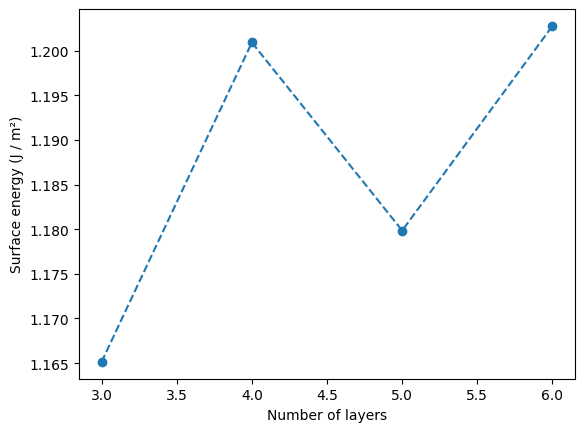

In [10]:
E_5layers,E_4layers,E_3layers = -613.65440386,-490.91006947,-368.16871025
def E_surf_cal(energy_bulk,energy_layers,layers):
    E_layers = energy_layers
    E_surf = 1/(2*4.200396*4.8502)*(E_layers-layers*energy_bulk) 
    E_surf_rya = E_surf/Bohr_to_A**2
    E_surf_jm = (E_surf/Bohr_to_A**2)*Ry_to_eV*eV_to_J*(1e20)
    return np.array([E_surf,E_surf_rya,E_surf_jm])
    
energies = []
for i in range(3, 7):
    energy_layers = globals()[f"E_{i}layers"]
    energy = E_surf_cal(energy_bulk=E_bulk, energy_layers=energy_layers, layers=i)
    energies.append(energy)

energies_layers = np.array(energies)
layers = np.arange(3,7,1)
plt.xlabel('Number of layers')
plt.ylabel('Surface energy (J / m²)')
plt.plot(layers,energies_layers[:,2],linestyle='--',marker='o');


From the figure the trend we see that the cumulative differences get smaller by increasing the number of layers:


In [11]:
energies_jm = energies_layers[:,2]
display(energies_jm[-1]-energies_jm[-2],
       energies_jm[1]-energies_jm[0])

0.022918732845574885

0.035777647268443236


Theoretical values can be found here: https://legacy.materialsproject.org/materials/mp-30/#surfaces; note that for (111) surface the calculated value gives 1.20 J/m².

Higher surface energy indicates a higher reactivity -- this is because Esurf is related to the cost of constructing the layers, higher Esurf = higher cost = higher reactive (i.e. "less stable surface").

In [12]:
2.54/2 # from tribchem package E_adh

1.27

In [13]:
E_9layers = -1104.62672516
E_surf_cal(E_bulk,E_9layers,9)

array([0.00153052, 0.00546559, 1.1914327 ])

Note that the results obtained are a bit different to the literature ones (only theoretical): 1.34 (VASP, R2SCAN functional) and 1.19 (QE, PBE functional); in J/m².

## Task 3: Calculation of absorption energies - H$_2$O, OH, H in Cu(111)

The aim now is to study how H2O will interact with our surface, for that, we can calculate the adsorption energy by comparing with the isolated systems (H2O and surface, isolated). Of course, there will be many absorption places we can try and check which one is best (hollow-hcp, hollow-fcc, on-top).

$$ E_{ads} = E_{surf+mol} - E_{surf} - E_{mol}$$

We can test the energy gain by adsorb the split molecule (i.e. OH, H -- tested by most favourable site) -- chemisorption energy (reaction energy).

*For the NxN cell (surface), it is smart to relax the 1x1 cell and replicate that structure...*

To start, it is better to consider the molecule at a small distance from the surface, so that we do not miss the global minimum; 1.5 A as a rule of thumb.

In [14]:
E_h2o = -34.77737505 # Ry , 'mp'
E_surf = -1963.64264000 # Ry, 16 atoms 2x2 surface model, 4 layers

Here we will calculate E_ads to see which position is the more favourable. For simplicity, we can fix the x and y coordinates of the O atom, and also the Cu atoms of the 4 last layers (assuming they do not vary much). 

### How to build the models: H2O adsorption and 2x2 surface

We build the model by subtracting the xyz coordinates from the isolated water molecule simply by subtraction -- it is even easier to do it by using VESTA and avogadro. We can export coordinates in VESTA using POSCAR (which uses fractional coordinates...) then open it with avogadro, and copy-paste the xyz file which can be direclty read by avogadro.

To build the 2x2 surface is NOT difficult in this case even doing it by hand (we have quite a symmetryc lattice) however becomes a hassle when thinking of > orthorhombic lattices (at least for me). I believe my approach is quite simple for ALL lattices: 

1. Using XCrySDen, we can build the lattice we want by going to the `Display` --> units of repetition. In case we want a 2x2 supercell in the x and y directions, we type 2 and 2 in those ones. Before it, we should have selected the asymmetric unit cell as repeting unit.
2. We save the state as a *.xsf file, which is human readable, and there we simply find the atomic coordinates
```bash
$ grep -A 16 "ATOMS" 2x2_1_asym.xsf 
 ATOMS
   29    0.0000000000    0.0000000000    6.2782601480
   29    1.2833029000    0.7409152000    4.1956962350
   29    0.0000000000    1.4818306000    2.0911784650
   29    0.0000000000    0.0000000000    0.0086208520
   29   -1.2833042090    2.2227480910    6.2782601480
   29   -0.0000013090    2.9636632910    4.1956962350
   29   -1.2833042090    3.7045786910    2.0911784650
   29   -1.2833042090    2.2227480910    0.0086208520
   29    2.5666084180    0.0000000000    6.2782601480
   29    3.8499113180    0.7409152000    4.1956962350
   29    2.5666084180    1.4818306000    2.0911784650
   29    2.5666084180    0.0000000000    0.0086208520
   29    1.2833042090    2.2227480910    6.2782601480
   29    2.5666071090    2.9636632910    4.1956962350
   29    1.2833042090    3.7045786910    2.0911784650
   29    1.2833042090    2.2227480910    0.0086208520
```
The XSF format (http://www.xcrysden.org/doc/XSF.html) has all coordinates in Angstroms and forces in Hartree/Angstroms.

3. To put it in QE-readable format, we should change the 29 -> atom type (Cu in this case) can be done i.e. with `sed` command.

In [15]:
E_surf_h2o_hcp = -1998.42128778 # value after 19 iterations, not fully converged (!)
E_surf_h2o_top = -1998.4299948902 # converged, after 28 bfgs steps; did not change much E_ads

In [16]:
E_ads_hcp = (-1998.42128778 + 34.77737505 + 1963.64264000)*Ry_to_eV
E_ads_top = (-1998.4299948902 + 34.77737505 + 1963.64264000)*Ry_to_eV
display(E_ads_hcp,E_ads_top)

-0.017316387621516875

-0.1357827514920236

On-top final distance is 2.5324 Angstroms wrt surface layer.

We can do the same for OH and H separately (searching for the most stable position for each fragment); then mixing both in same cell we can calculate E$_{OH-H}$. We expect that the metals with higher surface energy will have more favourable E$_{OH-H}$. We can use 1x1 for these examples, try both.

According to the calculations performed in _Vacuum_ 128 (2016) 252-258, it seems OH most favourable position is O-bounded in FCC-hollow position: I am calculating the on-top O-bonded (as for H2O) and that one to test out the difference. For the H, it seems they have FCC-hollow as well.

In [7]:
#finished @ violet, check and put results here
E_H = -492.08831182 # fcc
E_OH = -524.45195051 # fcc
#E_OH-H try


841.3070001699999


## Task 4: H$_2$O in the interface of Cu(111) bilayer

See notes Lab7: https://virtuale.unibo.it/pluginfile.php/1915558/mod_resource/content/1/LAB6_interface_calculations.pdf

Confination of molecules can result in their splitting (so-called "mechanochemistry" experiments); effect of the pressure in the molecule - does that happen in the case of Cu? It will provided that the energy gain is larger than the energy barrier of H2O splitting. Let's study that.

We simply test different confiment levels (varying z), we will see an energy increase up until the splitting occurs, where the energy decreases. Naturally, we keep constant z during relax, for which we will see forces higher than 10$^{-3}$ Ry/Bohr - we will thus read the forces acting on the atoms that we fixed.

Once we finished the molecule + surface relaxed, we can create the same surface using `awk`:

1. Copy coordinates of our slab model (2x2 surface, 4 layers) and change z coordinates to -z (basically reflects on the z axis the slab).


2. Shift slab above H2O molecule. We can use for that knowing the z-coordinate of the O atom: $-z+2*coord(O)_z$
